# Keras Model - BERTmultilingual

Here we'll be finetuning a bertmultilingual model using the Keras api.

Making the necessary imports.

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from transformers import BertTokenizer, TFBertForSequenceClassification

## Preparing the data

Reading the data and renaming the `y` column.

In [5]:
data = pd.read_csv(
    "/kaggle/input/financial-phrase-bank-portuguese-translation/financial_phrase_bank_pt_br.csv"
)
data = data.rename(columns={"y": "labels"})

Droping the `text` column, here we have an english column, and we're interested in finetuning the model using the portugues column.

In [6]:
data = data.drop(columns=["text"])

Transforming the `labels` columns so it represents our data in a way that the model will understand to predict.

In [7]:
def transform(x: str):
    if x == "neutral":
        return 2
    elif x == "negative":
        return 1
    else:
        return 0


data["labels"] = data["labels"].apply(transform)

Droping all rows where we don't have any text.

In [8]:
data = data.dropna(subset=["text_pt"])

Setting lists for the labels and the text.

In [9]:
text = data["text_pt"].tolist()
labels = data["labels"].tolist()

Importing our base model and the tokenizer.

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model = TFBertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", num_labels=3
)

"Tokenizing" our texts.

In [12]:
encodings = tokenizer(text, truncation=True, padding=True)

Making the separation between train, test and validation for using during training.

We're using `scikit-learn train_test_split` so we can have the following ratio:

70% - training

15% - validation

15% - tests

In [13]:
input_ids = encodings["input_ids"]
attention_masks = encodings["attention_mask"]
token_type_ids = encodings["token_type_ids"]

# Split the encoded data and labels into train and temporary sets
train_inputs, tmp_inputs, train_labels, tmp_labels = train_test_split(
    input_ids, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels
)
train_masks, tmp_masks, _, _ = train_test_split(
    attention_masks,
    labels,
    test_size=0.3,
    random_state=42,
    shuffle=True,
    stratify=labels,
)
train_token_type_ids, tmp_token_type_ids, _, _ = train_test_split(
    token_type_ids,
    labels,
    test_size=0.3,
    random_state=42,
    shuffle=True,
    stratify=labels,
)

# Split the temporary set into validation and test sets
val_inputs, test_inputs, val_labels, test_labels = train_test_split(
    tmp_inputs,
    tmp_labels,
    test_size=0.5,
    random_state=42,
    shuffle=True,
    stratify=tmp_labels,
)
val_masks, test_masks, _, _ = train_test_split(
    tmp_masks,
    tmp_labels,
    test_size=0.5,
    random_state=42,
    shuffle=True,
    stratify=tmp_labels,
)
val_token_type_ids, test_token_type_ids, _, _ = train_test_split(
    tmp_token_type_ids,
    tmp_labels,
    test_size=0.5,
    random_state=42,
    shuffle=True,
    stratify=tmp_labels,
)

Setting our datasets using `Tensorflow` datasets so we can pass it to the model.

In [ ]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            {
                "input_ids": train_inputs,
                "attention_mask": train_masks,
                "token_type_ids": train_token_type_ids,
            },
            train_labels,
        )
    )
    .shuffle(100)
    .batch(2)
)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {
            "input_ids": val_inputs,
            "attention_mask": val_masks,
            "token_type_ids": val_token_type_ids,
        },
        val_labels,
    )
).batch(2)

test_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {
            "input_ids": test_inputs,
            "attention_mask": test_masks,
            "token_type_ids": test_token_type_ids,
        },
        test_labels,
    )
).batch(2)

## Training

Before training we set our hyperparameter optimizer, early stopping parameters and loss function.

Then we call the `fit` method to train the model.

In [14]:
early_stopping = EarlyStopping(
    patience=5, monitor="val_loss", restore_best_weights=True
)
# Fine-tune the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-6)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
history = model.fit(
    train_dataset, validation_data=val_dataset, epochs=20, callbacks=[early_stopping]
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_dataset)

print("Test loss:", loss)
print("Test accuracy:", accuracy)

Epoch 1/20
1696/1696 [==============================] - 268s 130ms/step - loss: 0.7683 - accuracy: 0.6556 - val_loss: 0.5829 - val_accuracy: 0.7510
Epoch 2/20
1696/1696 [==============================] - 207s 122ms/step - loss: 0.4883 - accuracy: 0.8080 - val_loss: 0.4782 - val_accuracy: 0.8116
Epoch 3/20
1696/1696 [==============================] - 210s 124ms/step - loss: 0.3348 - accuracy: 0.8717 - val_loss: 0.4850 - val_accuracy: 0.8157
Epoch 4/20
1696/1696 [==============================] - 211s 124ms/step - loss: 0.2406 - accuracy: 0.9115 - val_loss: 0.5098 - val_accuracy: 0.8267
Epoch 5/20
1696/1696 [==============================] - 203s 120ms/step - loss: 0.1688 - accuracy: 0.9387 - val_loss: 0.5955 - val_accuracy: 0.8171
Epoch 6/20
1696/1696 [==============================] - 203s 120ms/step - loss: 0.1183 - accuracy: 0.9625 - val_loss: 0.6266 - val_accuracy: 0.8198
Epoch 7/20
364/364 [==============================] - 15s 41ms/step - loss: 0.5119 - accuracy: 0.7964
Test loss:

## Evaluating the model

Checking the model test loss and accuracy.

In [18]:
loss, accuracy = model.evaluate(test_dataset)

print("Test loss:", loss)
print("Test accuracy:", accuracy)

364/364 [==============================] - 15s 40ms/step - loss: 0.5119 - accuracy: 0.7964
Test loss: 0.5119097232818604
Test accuracy: 0.7964236736297607


Plotting the model train and val(eval) losses per epoch graph.

Text(0, 0.5, 'loss')

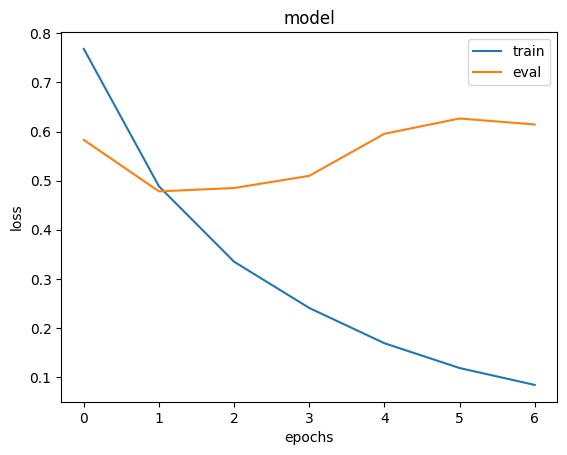

In [23]:
epochs = history.epoch
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.title("model")
plt.plot(loss, label="train")
plt.plot(val_loss, label="eval")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

Remaking the test dataset so we can make predictions and get better test metrics.

In [25]:
predict_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {
            "input_ids": test_inputs,
            "attention_mask": test_masks,
            "token_type_ids": test_token_type_ids,
        }
    )
).batch(2)
pred = model.predict(predict_dataset)

364/364 [==============================] - 17s 38ms/step


Passing each prediction to its own value in a list.

In [33]:
rpred = [x.argmax().tolist() for x in pred[0]]

Comparing the predicted labels and the true labels and getting more interesting metrics, also ploting a confusion matrix for better metric visualization.

                       model Metrics

              precision    recall  f1-score   support

           0       0.70      0.71      0.71       204
           1       0.68      0.75      0.71        91
           2       0.87      0.85      0.86       432

    accuracy                           0.80       727
   macro avg       0.75      0.77      0.76       727
weighted avg       0.80      0.80      0.80       727

Accuracy score  =  0.796423658872077
Precision score =  0.7994988907589828
Recall score    =  0.796423658872077



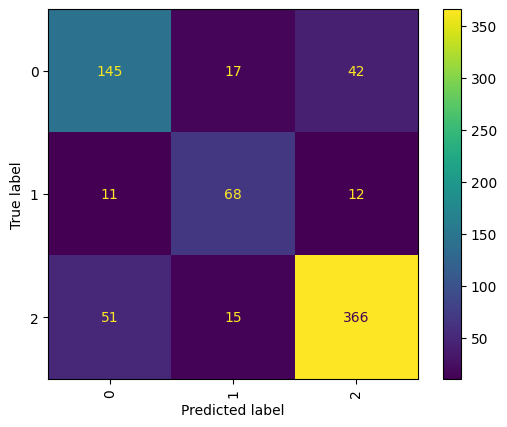

In [35]:
print("                       model Metrics")
print()
print(metrics.classification_report(test_labels, rpred))
print("Accuracy score  = ", metrics.accuracy_score(test_labels, rpred))
print(
    "Precision score = ",
    metrics.precision_score(test_labels, rpred, average="weighted"),
)
print(
    "Recall score    = ", metrics.recall_score(test_labels, rpred, average="weighted")
)
print()
confusionmatrix = metrics.confusion_matrix(test_labels, rpred)
confusion = metrics.ConfusionMatrixDisplay(confusionmatrix)
confusion.plot(xticks_rotation="vertical")